In [1]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
#import xarray as xr
import pandas as pd
import joblib
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/tomislav_galjanic/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# shape library
import shap

In [5]:
# print the JS visualization code to the notebook
shap.initjs()

In [6]:
os.getcwd()

'/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/Modeling'

In [7]:
train_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/train.csv')
test_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/test.csv')

In [8]:
def per_pop(population, feature):
    if population > 0:
        return 100 * feature/population
    else:
        return np.nan

In [9]:
train_df['EVICTIONS'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
train_df['AFAM'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
train_df['WHITE'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
train_df['HISPANIC'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [10]:
train_df.describe()

EP_UNEMP         EP_PCI        EP_POV      EP_NOVEH     EP_NOHSDP  \
count  11892.000000   11907.000000  11884.000000  11878.000000  11911.000000   
mean       7.951892   28557.180986     16.459635      9.359151     12.745294   
std        5.538075   13485.964541     12.734019     11.922755      9.427160   
min        0.000000     238.000000      0.000000      0.000000      0.000000   
25%        4.300000   19966.000000      7.200000      2.500000      5.700000   
50%        6.500000   25738.000000     13.100000      5.400000     10.400000   
75%       10.000000   33788.000000     22.200000     11.000000     17.600000   
max       59.300000  140255.000000    100.000000    100.000000     66.900000   

          EP_MOBILE     EP_MINRTY      EP_CROWD      EP_AGE65      EP_AGE17  \
count  11881.000000  11989.000000  11989.000000  11912.000000  11989.000000   
mean       6.583116     32.903637      2.497798     15.466429     22.105030   
std       11.411780     27.998938      3.490491      7.688546      6.699485   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      9.700000      0.400000     10.500000     18.700000   
50%        0.800000     23.900000      1.400000     14.900000     22.400000   
75%        8.300000     50.200000      3.300000     19.000000     26.000000   
max      100.000000    100.000000    100.000000    100.000000     53.600000   

               AFAM         WHITE      HISPANIC    WFIR_AFREQ    HRCN_AFREQ  \
count  11913.000000  11913.000000  11913.000000  11970.000000  10340.000000   
mean       0.362745      3.378306      0.309017      0.000300      0.093429   
std        0.594257      2.388544      0.499495      0.001233      0.093278   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.027579      1.784615      0.044199      0.000003      0.011968   
50%        0.126077      3.182686      0.134626      0.000023      0.065002   
75%        0.448029      4.571704      0.362976      0.000134      0.161570   
max        9.983361     50.000000     13.135593      0.048083      0.443213   

        CFLD_AFREQ    RFLD_AFREQ    HWAV_AFREQ    POPULATION     EVICTIONS  
count  5522.000000  11970.000000  11970.000000  12023.000000  11913.000000  
mean      1.028563      1.850286      0.882896   4261.110538      0.551709  
std       1.634605      1.960736      1.399491   2167.705352      0.776101  
min       0.000000      0.000000      0.000000      0.000000      0.000000  
25%       0.000000      0.583333      0.082372   2852.000000      0.094572  
50%       0.002000      1.458333      0.411862   4001.000000      0.255247  
75%       2.049602      2.458333      0.988468   5346.500000      0.668258  
max       4.512000     12.666670      8.731466  53812.000000      9.935760

In [11]:
test_df['EVICTIONS'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
test_df['AFAM'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
test_df['WHITE'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
test_df['HISPANIC'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [12]:
test_df.describe()

EP_UNEMP         EP_PCI       EP_POV     EP_NOVEH    EP_NOHSDP  \
count  2973.000000    2976.000000  2972.000000  2971.000000  2977.000000   
mean      8.067037   28391.974126    16.993102     9.880781    12.979342   
std       5.533451   13515.934969    12.935581    12.950432     9.808189   
min       0.000000       6.000000     0.000000     0.000000     0.000000   
25%       4.400000   19736.250000     7.300000     2.650000     5.700000   
50%       6.600000   25543.500000    13.600000     5.500000    10.500000   
75%      10.000000   33482.250000    23.425000    11.450000    18.000000   
max      43.800000  139678.000000   100.000000   100.000000   100.000000   

         EP_MOBILE    EP_MINRTY     EP_CROWD     EP_AGE65     EP_AGE17  \
count  2972.000000  2996.000000  2996.000000  2977.000000  2996.000000   
mean      6.413190    33.215454     2.549599    15.430131    22.030207   
std      11.392921    28.191928     3.892751     7.983248     6.838481   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    10.100000     0.400000    10.500000    18.600000   
50%       0.700000    23.700000     1.400000    14.700000    22.400000   
75%       8.100000    50.575000     3.200000    18.900000    26.000000   
max     100.000000   100.000000   100.000000   100.000000    53.900000   

              AFAM        WHITE     HISPANIC   WFIR_AFREQ   HRCN_AFREQ  \
count  2978.000000  2978.000000  2978.000000  2993.000000  2577.000000   
mean      0.349333     3.320683     0.292315     0.000293     0.092543   
std       0.571294     2.477493     0.499347     0.001192     0.094678   
min       0.000000     0.000000     0.000000     0.000000     0.005361   
25%       0.028211     1.694489     0.044336     0.000003     0.011968   
50%       0.122894     3.095142     0.126396     0.000021     0.059841   
75%       0.422833     4.494787     0.340929     0.000132     0.161570   
max       7.861793    38.068182    11.111111     0.035338     0.430854   

        CFLD_AFREQ   RFLD_AFREQ   HWAV_AFREQ    POPULATION    EVICTIONS  
count  1394.000000  2994.000000  2994.000000   3008.000000  2978.000000  
mean      1.006092     1.830122     0.938766   4293.026596     0.589067  
std       1.637243     1.921024     1.450644   2103.466846     1.269408  
min       0.000000     0.000000     0.000000      0.000000     0.000000  
25%       0.000000     0.541667     0.164745   2859.500000     0.097182  
50%       0.002000     1.458333     0.494234   4066.000000     0.269906  
75%       2.037666     2.458333     0.988468   5432.000000     0.686516  
max       4.512000    12.666670     8.731466  28926.000000    52.941176

In [13]:
XY_var = list(train_df.columns)
XY_var.pop(0)
XY_var

['EP_UNEMP',
 'EP_PCI',
 'EP_POV',
 'EP_NOVEH',
 'EP_NOHSDP',
 'EP_MOBILE',
 'EP_MINRTY',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ',
 'POPULATION',
 'EVICTIONS']

In [14]:
corr_train = train_df[XY_var].corr()
corr_train_df = pd.DataFrame(corr_train, index=XY_var, columns=XY_var)

<Axes:title={'center':'Training data corrrelation'}>

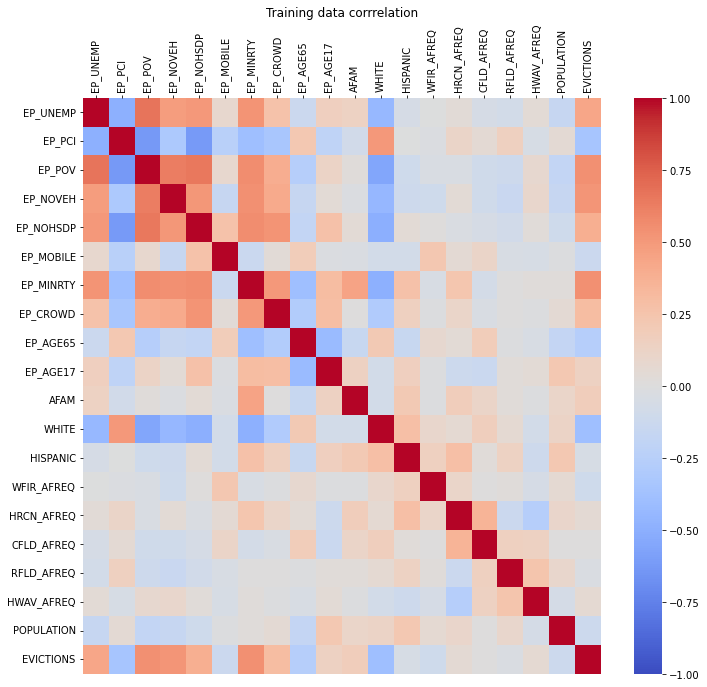

In [15]:
fig = plt.figure(figsize = (9,8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_ticks_position("top")
plt.title("Training data corrrelation")
sns.heatmap(corr_train_df, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

In [16]:
corr_train

EP_UNEMP    EP_PCI    EP_POV  EP_NOVEH  EP_NOHSDP  EP_MOBILE  \
EP_UNEMP    1.000000 -0.494504  0.667656  0.480295   0.505420   0.081013   
EP_PCI     -0.494504  1.000000 -0.627638 -0.315351  -0.624941  -0.242241   
EP_POV      0.667656 -0.627638  1.000000  0.625888   0.650145   0.081327   
EP_NOVEH    0.480295 -0.315351  0.625888  1.000000   0.509378  -0.157552   
EP_NOHSDP   0.505420 -0.624941  0.650145  0.509378   1.000000   0.258484   
EP_MOBILE   0.081013 -0.242241  0.081327 -0.157552   0.258484   1.000000   
EP_MINRTY   0.523932 -0.395673  0.557239  0.545769   0.561454  -0.135218   
EP_CROWD    0.260525 -0.339120  0.391731  0.412020   0.530635   0.031791   
EP_AGE65   -0.131219  0.226022 -0.261701 -0.157763  -0.185375   0.184242   
EP_AGE17    0.158638 -0.204797  0.123653  0.041187   0.268560  -0.019484   
AFAM        0.137845 -0.091611  0.022880 -0.018980   0.044132  -0.029871   
WHITE      -0.442633  0.502674 -0.558273 -0.449826  -0.505274  -0.080464   
HISPANIC   -0.060405 -0.003104 -0.103589 -0.114913   0.044502  -0.080243   
WFIR_AFREQ -0.007802 -0.023061 -0.031918 -0.103168   0.014053   0.230295   
HRCN_AFREQ  0.038120  0.113074 -0.033659  0.046226  -0.025519   0.049931   
CFLD_AFREQ -0.056012  0.054050 -0.096322 -0.095743  -0.054705   0.110151   
RFLD_AFREQ -0.082464  0.153281 -0.112155 -0.147296  -0.092834  -0.045591   
HWAV_AFREQ  0.043835 -0.053258  0.071541  0.091013   0.027118  -0.050702   
POPULATION -0.159476  0.053508 -0.187447 -0.163215  -0.107469  -0.009269   
EVICTIONS   0.436363 -0.348056  0.539311  0.521911   0.390142  -0.125341   

            EP_MINRTY  EP_CROWD  EP_AGE65  EP_AGE17      AFAM     WHITE  \
EP_UNEMP     0.523932  0.260525 -0.131219  0.158638  0.137845 -0.442633   
EP_PCI      -0.395673 -0.339120  0.226022 -0.204797 -0.091611  0.502674   
EP_POV       0.557239  0.391731 -0.261701  0.123653  0.022880 -0.558273   
EP_NOVEH     0.545769  0.412020 -0.157763  0.041187 -0.018980 -0.449826   
EP_NOHSDP    0.561454  0.530635 -0.185375  0.268560  0.044132 -0.505274   
EP_MOBILE   -0.135218  0.031791  0.184242 -0.019484 -0.029871 -0.080464   
EP_MINRTY    1.000000  0.500723 -0.393476  0.300892  0.448679 -0.495516   
EP_CROWD     0.500723  1.000000 -0.284238  0.292757  0.002116 -0.295063   
EP_AGE65    -0.393476 -0.284238  1.000000 -0.423751 -0.150188  0.217097   
EP_AGE17     0.300892  0.292757 -0.423751  1.000000  0.146463 -0.084231   
AFAM         0.448679  0.002116 -0.150188  0.146463  1.000000 -0.079873   
WHITE       -0.495516 -0.295063  0.217097 -0.084231 -0.079873  1.000000   
HISPANIC     0.271573  0.151971 -0.150216  0.159874  0.214894  0.282341   
WFIR_AFREQ  -0.046169 -0.009739  0.074157 -0.008671 -0.015409  0.087494   
HRCN_AFREQ   0.235594  0.102497  0.040198 -0.118523  0.178778  0.059448   
CFLD_AFREQ  -0.077628 -0.031708  0.180654 -0.139132  0.114516  0.169694   
RFLD_AFREQ   0.007396  0.002890 -0.012107  0.026828  0.025014  0.062424   
HWAV_AFREQ   0.020745 -0.008243 -0.043878  0.040827 -0.008216 -0.082834   
POPULATION   0.016362  0.048259 -0.176225  0.225465  0.108224  0.119429   
EVICTIONS    0.545172  0.298167 -0.260023  0.144340  0.174300 -0.391413   

            HISPANIC  WFIR_AFREQ  HRCN_AFREQ  CFLD_AFREQ  RFLD_AFREQ  \
EP_UNEMP   -0.060405   -0.007802    0.038120   -0.056012   -0.082464   
EP_PCI     -0.003104   -0.023061    0.113074    0.054050    0.153281   
EP_POV     -0.103589   -0.031918   -0.033659   -0.096322   -0.112155   
EP_NOVEH   -0.114913   -0.103168    0.046226   -0.095743   -0.147296   
EP_NOHSDP   0.044502    0.014053   -0.025519   -0.054705   -0.092834   
EP_MOBILE  -0.080243    0.230295    0.049931    0.110151   -0.045591   
EP_MINRTY   0.271573   -0.046169    0.235594   -0.077628    0.007396   
EP_CROWD    0.151971   -0.009739    0.102497   -0.031708    0.002890   
EP_AGE65   -0.150216    0.074157    0.040198    0.180654   -0.012107   
EP_AGE17    0.159874   -0.008671   -0.118523   -0.139132    0.026828   
AFAM        0.214894   -0.015409    0.178778   

### Examine multicollinearity between features using Variance Inflation Factor

In [17]:
X_var = copy.deepcopy(XY_var)
X_var.remove('EVICTIONS')
X_var.remove('POPULATION')
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [18]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         54.274716
EP_MINRTY      5.748367
EP_POV         3.815474
EP_NOHSDP      3.468006
EP_NOVEH       3.041253
WHITE          2.684534
EP_PCI         2.452304
EP_UNEMP       2.240264
EP_CROWD       1.877264
AFAM           1.670352
EP_AGE65       1.635415
EP_AGE17       1.608447
HISPANIC       1.568768
HRCN_AFREQ     1.520386
RFLD_AFREQ     1.452642
EP_MOBILE      1.440626
HWAV_AFREQ     1.396111
CFLD_AFREQ     1.302713
WFIR_AFREQ     1.123669
dtype: float64

In [19]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ'
]
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [20]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         44.929572
EP_NOVEH       2.199315
WHITE          2.048691
EP_PCI         1.962866
EP_UNEMP       1.776803
EP_CROWD       1.723336
EP_AGE65       1.559881
EP_AGE17       1.499917
HRCN_AFREQ     1.454215
RFLD_AFREQ     1.448442
HWAV_AFREQ     1.384048
HISPANIC       1.309997
EP_MOBILE      1.298389
CFLD_AFREQ     1.297645
AFAM           1.206151
WFIR_AFREQ     1.122971
dtype: float64

### Final feature selection and data prep

In [21]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ']
Y_var = ['EVICTIONS']

In [22]:
#train_sel = ~train_df[X_var+Y_var].isna().any(axis=1)
train_sel = ~train_df[Y_var].isna().any(axis=1)
sum(train_sel)

11913

In [23]:
#X_train = train_df.loc[train_sel,X_var].to_numpy()
y_train = train_df.loc[train_sel,Y_var].to_numpy().ravel()
X_train = train_df.loc[train_sel,X_var]
#y_train = train_df.loc[train_sel,Y_var]

In [24]:
#test_sel = ~test_df[X_var+Y_var].isna().any(axis=1)
test_sel = ~test_df[Y_var].isna().any(axis=1)
sum(test_sel)

2978

In [25]:
#X_test = test_df.loc[test_sel,X_var].to_numpy()
y_test = test_df.loc[test_sel,Y_var].to_numpy().ravel()
X_test = test_df.loc[test_sel,X_var]
#y_test = test_df.loc[test_sel,Y_var]

## HistGBoost (Poisson) Model Specification

In [26]:
# Parameter grids
hgbr_param_grid = {"max_iter":[100, 250, 500, 1000],
                 "max_depth":[3,4,5,6]
                }

In [27]:
kf = KFold(n_splits=5).split(X_train,y_train)
hgbr_model = HistGradientBoostingRegressor(loss="poisson", random_state=123)
grid = GridSearchCV(hgbr_model, hgbr_param_grid, scoring='neg_mean_squared_error', cv=kf, return_train_score=False, refit=True)
#grid = GridSearchCV(hgbr_model, hgbr_param_grid, scoring='neg_mean_absolute_error', cv=kf, return_train_score=False, refit=True)

In [28]:
print(datetime.datetime.now())

grid.fit(X_train,y_train)
best_params = grid.best_params_
print(best_params)

print(datetime.datetime.now())

2021-12-01 19:11:15.995610
{'max_depth': 3, 'max_iter': 500}
2021-12-01 19:13:16.242467


In [29]:
print(grid.best_score_)

-0.2288606747052339


In [30]:
# Fit the model on train data using optimal hyperparameters 
hgbr_model = HistGradientBoostingRegressor(loss="poisson", random_state=123, **best_params)
hgbr_model.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson', max_depth=3, max_iter=500,
                              random_state=123)

##  HistGBoost (Poisson) Model Evaluation

In [31]:
def evaluate_predict(y, pred):
    scores = {
        'mse':mean_squared_error(y, pred),
        'rmse':np.sqrt(mean_squared_error(y, pred)),
        'mae':mean_absolute_error(y, pred),
        'medae':median_absolute_error(y, pred),
        'max_error':max_error(y, pred),
        'bias':pred.mean() - y.mean(),
        'r2':r2_score(y, pred),
        'corr':np.corrcoef(y,pred)[0,1],
        }
    return scores

### Train data metrics

In [32]:
# Calculate test data error metrics
y_pred_train = hgbr_model.predict(X_train)

resid_train = y_train - y_pred_train
df_results_train = pd.DataFrame({'y_train':y_train, 'y_pred_train': y_pred_train, 'resid_train': resid_train})

In [33]:
train_scores = evaluate_predict(y_train, y_pred_train)
train_scores

{'mse': 0.1518630570476757,
 'rmse': 0.3896961085867752,
 'mae': 0.23214320010955888,
 'medae': 0.12936590239924525,
 'max_error': 5.9776353412184395,
 'bias': 0.0006297150744187796,
 'r2': 0.7478540732721131,
 'corr': 0.866378510750725}

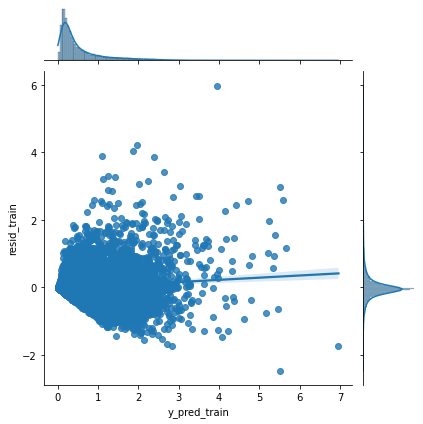

In [34]:
sns.jointplot(x = 'y_pred_train', y = 'resid_train', data = df_results_train, kind = 'reg')

### Test data metrics

In [35]:
# Calculate test data error metrics
y_pred_test = hgbr_model.predict(X_test)

resid_test = y_test - y_pred_test
df_results = pd.DataFrame({'y_test':y_test, 'y_pred_test': y_pred_test, 'resid_test': resid_test})

In [36]:
test_scores = evaluate_predict(y_test, y_pred_test)
test_scores

{'mse': 1.245578774911699,
 'rmse': 1.1160550053253195,
 'mae': 0.29802311015883687,
 'medae': 0.14118439272852204,
 'max_error': 52.89803667185393,
 'bias': -0.01511864883592029,
 'r2': 0.22675972313471993,
 'corr': 0.476934750042386}

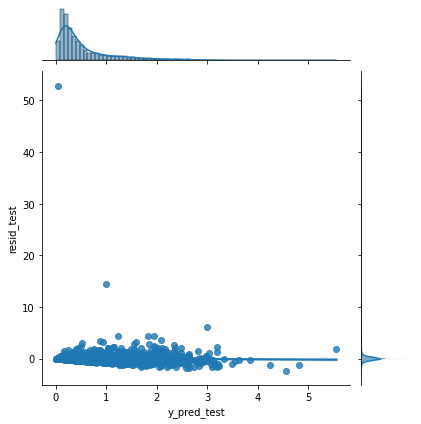

In [37]:
sns.jointplot(x = 'y_pred_test', y = 'resid_test', data = df_results, kind = 'reg')

[Text(0.5, 0, 'y_test predicted'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of y_test predicted'),
 (0.0, 1500.0)]

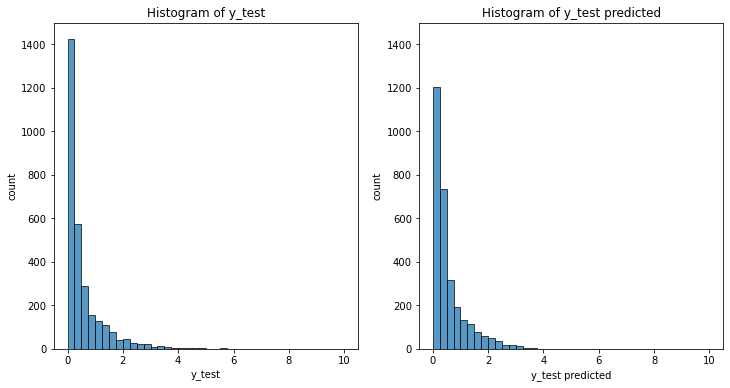

In [48]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.histplot(y_pred_test, kde=False,  binwidth = 0.25, binrange = (0,10), ax = ax[1])
sns.histplot(y_test, kde=False, binwidth = 0.25, binrange = (0,10), ax = ax[0])

ax[0].set(xlabel='y_test', ylabel='count', title='Histogram of y_test', ylim=[0,1500])
ax[1].set(xlabel='y_test predicted', ylabel='count', title='Histogram of y_test predicted', ylim=[0,1500])

<Axes:ylabel='Count'>

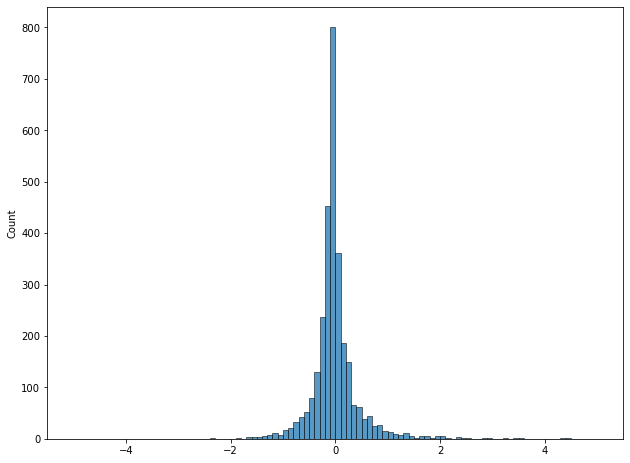

In [97]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_axes([0,0,1,1])
sns.histplot(resid_test, kde=False, binwidth = 0.1, binrange = (-5,5))

In [98]:
np.mean(y_test)

0.5890665721080095

In [99]:
np.std(y_test)

1.2691950385527446

## Feature importance with SHAP

In [89]:
# explain the model's predictions using SHAP
t_explainer = shap.TreeExplainer(hgbr_model)
t_shap_values = t_explainer(X_test)
shap_values = t_explainer.shap_values(X_test)

In [50]:
X_test

EP_UNEMP   EP_PCI  EP_NOVEH  EP_MOBILE  EP_CROWD  EP_AGE65  EP_AGE17  \
0          8.1  34105.0       5.8       18.0       1.0      15.6      27.0   
1          5.6  27375.0       2.2        1.2       1.3      11.8      19.4   
2          8.3  18550.0       9.4       21.3       1.2      14.0      19.0   
3          4.8  21590.0       4.4       33.5       1.8      19.5      16.1   
4          5.1  31525.0       1.3       10.7       1.0      18.3      25.0   
...        ...      ...       ...        ...       ...       ...       ...   
3003       1.7  29455.0       5.7        0.7       0.0      22.9      20.4   
3004       5.4  26965.0       2.6        6.1       1.8      15.9      23.8   
3005      12.3  26074.0       1.8        9.8       0.0      18.1      17.1   
3006       3.3  27676.0       2.7       13.1       2.9      27.9      20.1   
3007       2.4  27578.0       0.6       19.4       2.3      19.6      27.7   

          AFAM     WHITE  HISPANIC  WFIR_AFREQ  HRCN_AFREQ  CFLD_AFREQ  \
0     0.533417  4.016316  0.062755    0.000236    0.059841         NaN   
1     0.382857  5.264277  0.106349    0.000398    0.224305    2.065586   
2     0.378657  4.733219  0.086059    0.001536    0.239285    0.002000   
3     0.262217  3.980930  0.071514    0.001224    0.245347    2.055586   
4     0.195228  6.062907  0.108460    0.001419    0.245347    1.991761   
...        ...       ...       ...         ...         ...         ...   
3003  0.061406  2.272029  0.030703    0.000017         NaN         NaN   
3004  0.000000  2.229931  0.000000    0.000193         NaN         NaN   
3005  0.019670  1.927616  0.000000    0.000402         NaN         NaN   
3006  0.000000  3.732670  0.035549    0.000577         NaN         NaN   
3007  0.000000  2.772467  0.095602    0.002189         NaN         NaN   

      RFLD_AFREQ  HWAV_AFREQ  
0       1.083333    0.411862  
1       2.708333    0.836242  
2       2.708333    1.070840  
3       2.708333    1.070840  
4       2.708333    1.070840  
...          ...         ...  
3003    0.000000    0.494234  
3004    0.750000    0.494234  
3005    0.750000    0.494234  
3006    0.250000    0.000000  
3007    0.333333    0.000000  

[2978 rows x 15 columns]

In [90]:
t_explainer.expected_value

array([-1.09685864])

In [91]:
np.exp(t_explainer.expected_value)

array([0.3339184])

In [54]:
t_shap_values

.values =
array([[ 0.04867945, -0.08212203, -0.05147049, ...,  0.03338408,
        -0.06008737, -0.26904502],
       [-0.0404388 ,  0.12056605, -0.44874172, ..., -0.03042241,
         0.07894987,  0.0065034 ],
       [ 0.04374822,  0.08935321,  0.21970304, ..., -0.01301098,
         0.08462063,  0.04066399],
       ...,
       [ 0.13731945,  0.04145514, -0.41883847, ...,  0.03353206,
        -0.09775365,  0.09388886],
       [-0.15574132,  0.05763125, -0.26018947, ...,  0.06090137,
        -0.08603458,  0.21334766],
       [-0.22523996,  0.06855079, -0.54907608, ...,  0.06008211,
        -0.05285035,  0.18903006]])

.base_values =
array([[-1.09685864],
       [-1.09685864],
       [-1.09685864],
       ...,
       [-1.09685864],
       [-1.09685864],
       [-1.09685864]])

.data =
array([[8.10000000e+00, 3.41050000e+04, 5.80000000e+00, ...,
                   nan, 1.08333333e+00, 4.11861614e-01],
       [5.60000000e+00, 2.73750000e+04, 2.20000000e+00, ...,
        2.06558614e+00, 2.70

In [55]:
t_shap_values.values

array([[ 0.04867945, -0.08212203, -0.05147049, ...,  0.03338408,
        -0.06008737, -0.26904502],
       [-0.0404388 ,  0.12056605, -0.44874172, ..., -0.03042241,
         0.07894987,  0.0065034 ],
       [ 0.04374822,  0.08935321,  0.21970304, ..., -0.01301098,
         0.08462063,  0.04066399],
       ...,
       [ 0.13731945,  0.04145514, -0.41883847, ...,  0.03353206,
        -0.09775365,  0.09388886],
       [-0.15574132,  0.05763125, -0.26018947, ...,  0.06090137,
        -0.08603458,  0.21334766],
       [-0.22523996,  0.06855079, -0.54907608, ...,  0.06008211,
        -0.05285035,  0.18903006]])

In [56]:
shap_values

array([[ 0.04867945, -0.08212203, -0.05147049, ...,  0.03338408,
        -0.06008737, -0.26904502],
       [-0.0404388 ,  0.12056605, -0.44874172, ..., -0.03042241,
         0.07894987,  0.0065034 ],
       [ 0.04374822,  0.08935321,  0.21970304, ..., -0.01301098,
         0.08462063,  0.04066399],
       ...,
       [ 0.13731945,  0.04145514, -0.41883847, ...,  0.03353206,
        -0.09775365,  0.09388886],
       [-0.15574132,  0.05763125, -0.26018947, ...,  0.06090137,
        -0.08603458,  0.21334766],
       [-0.22523996,  0.06855079, -0.54907608, ...,  0.06008211,
        -0.05285035,  0.18903006]])

In [235]:
# visualize all the training set predictions
#shap.plots.force(t_shap_values)
shap.force_plot(t_explainer.expected_value, shap_values, X_var)

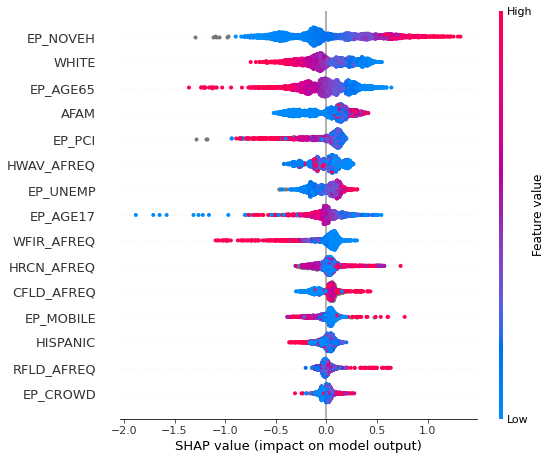

In [57]:
#shap.plots.beeswarm(t_shap_values, max_display=20)
shap.summary_plot(t_shap_values, X_test)

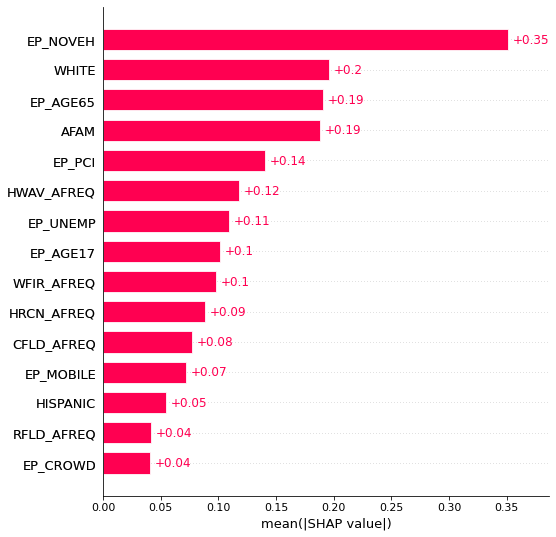

In [58]:
shap.plots.bar(t_shap_values, max_display=20)

### Dependence Plot: No Vehicles and Climate Disasters

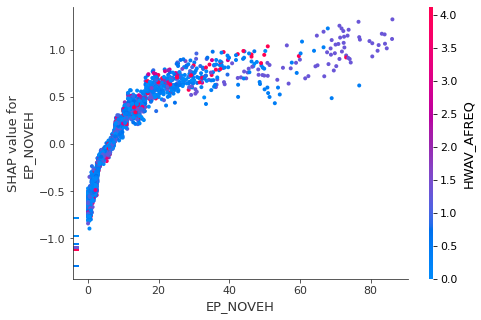

In [59]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HWAV_AFREQ")

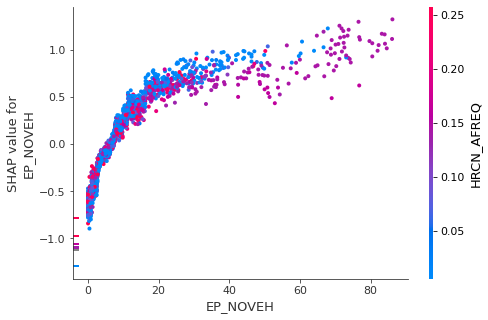

In [60]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HRCN_AFREQ")

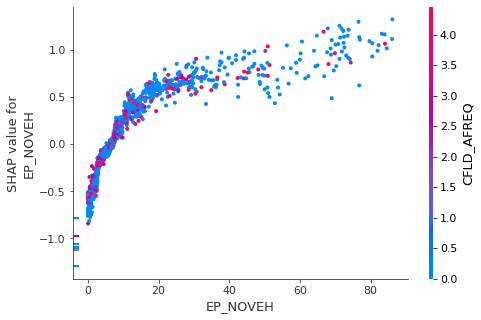

In [61]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="CFLD_AFREQ")

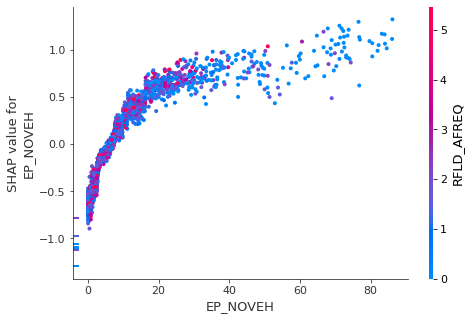

In [62]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="RFLD_AFREQ")

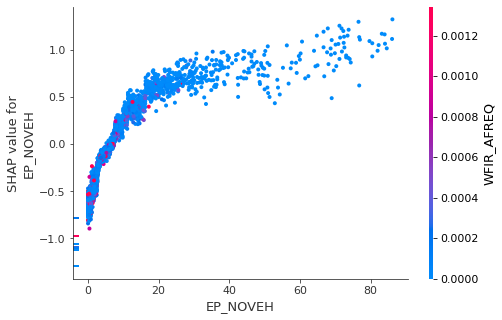

In [63]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: African-American (Mortgage Applicants) and Climate Disasters

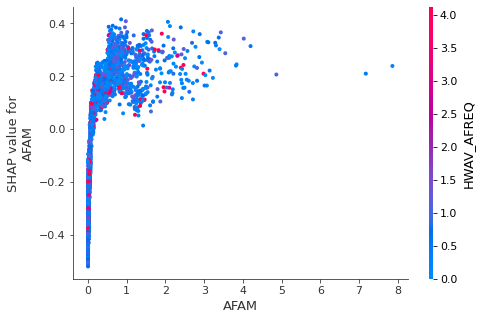

In [64]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HWAV_AFREQ")

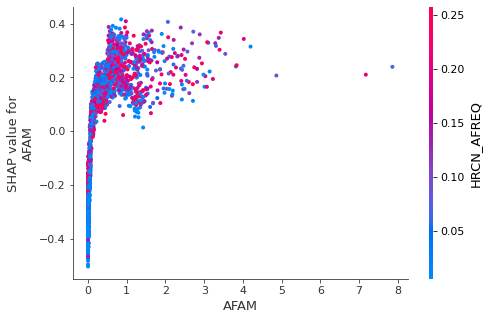

In [65]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HRCN_AFREQ")

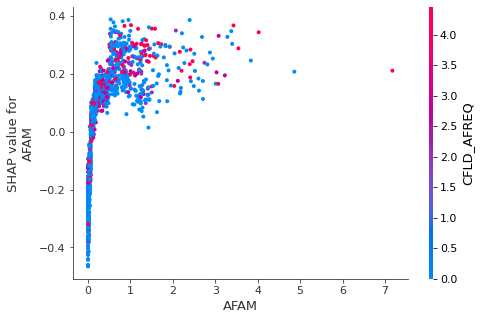

In [66]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="CFLD_AFREQ")

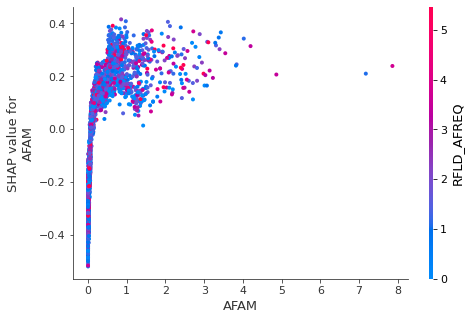

In [67]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="RFLD_AFREQ")

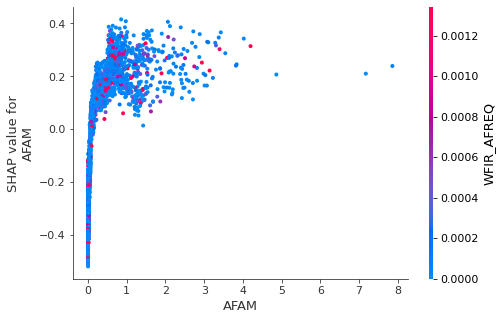

In [68]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: White (Mortgage Applicants) and Climate Disasters

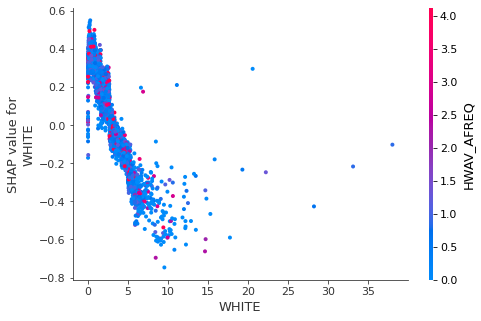

In [69]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HWAV_AFREQ")

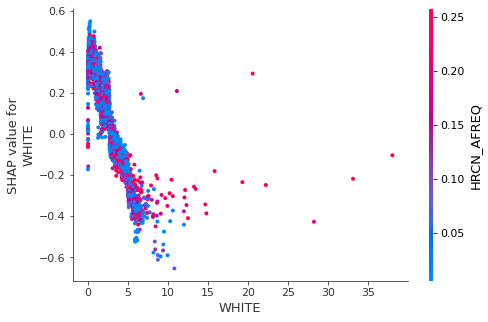

In [70]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HRCN_AFREQ")

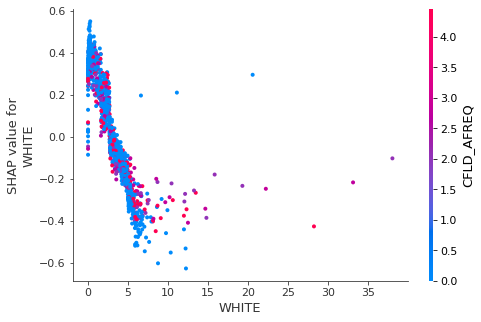

In [71]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="CFLD_AFREQ")

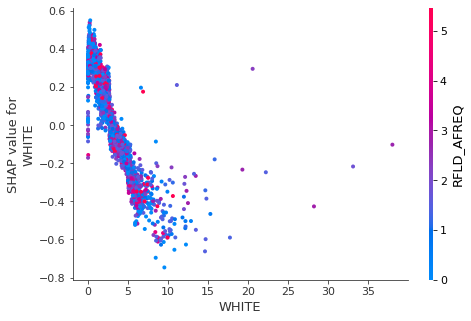

In [72]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="RFLD_AFREQ")

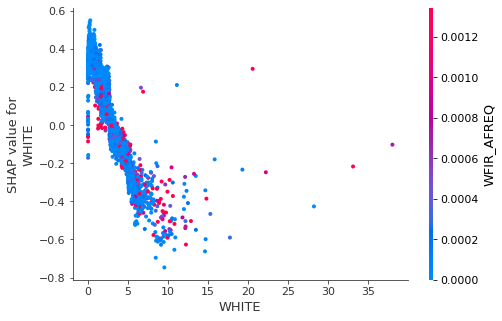

In [73]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: Top Interaction for Each Feature

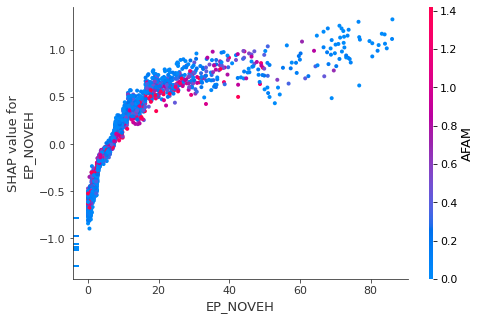

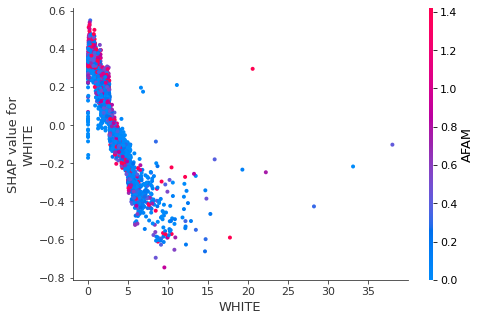

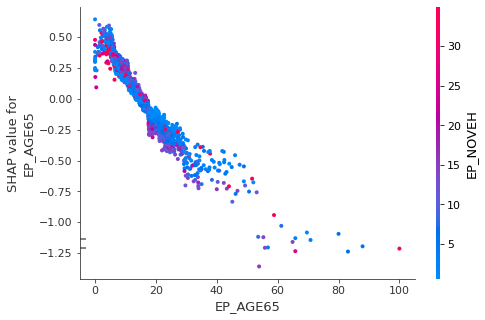

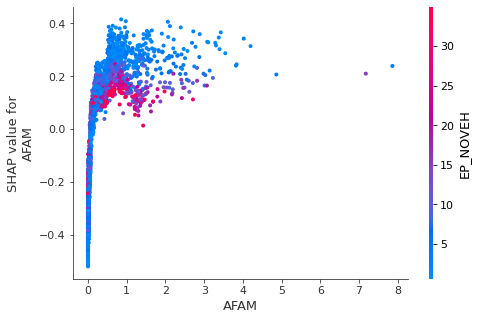

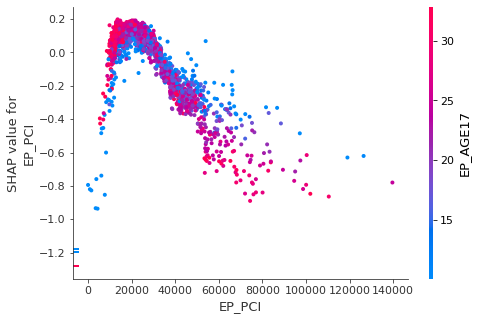

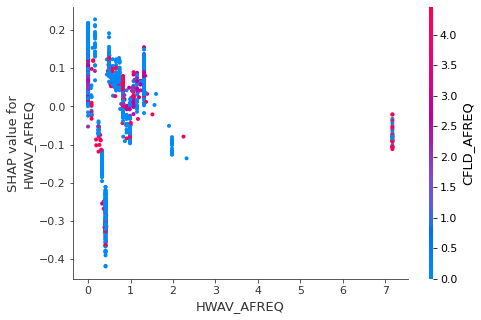

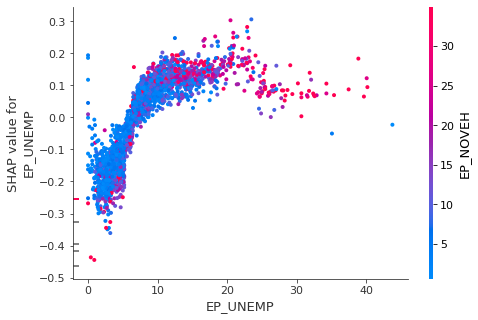

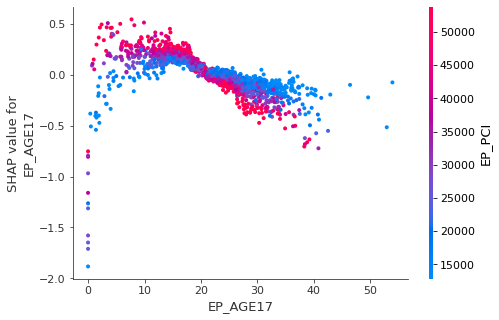

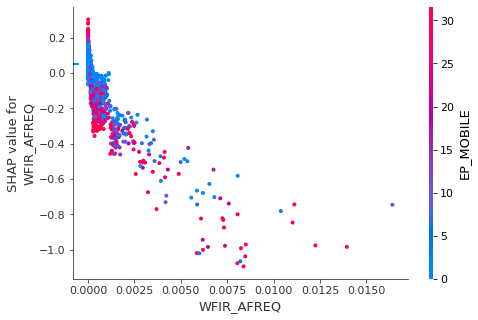

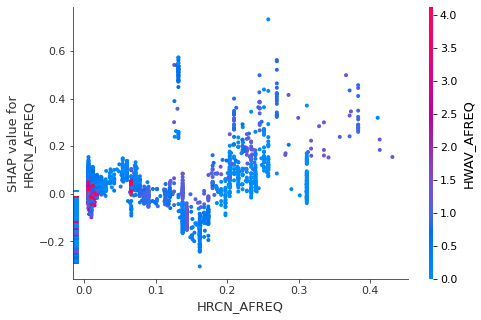

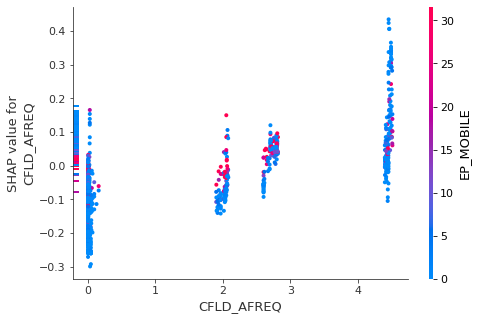

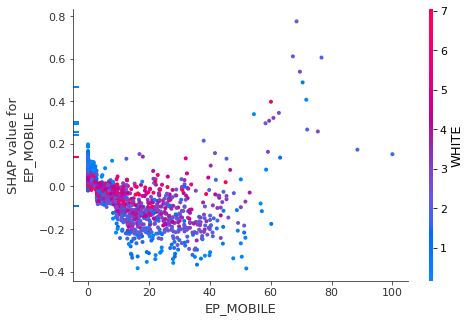

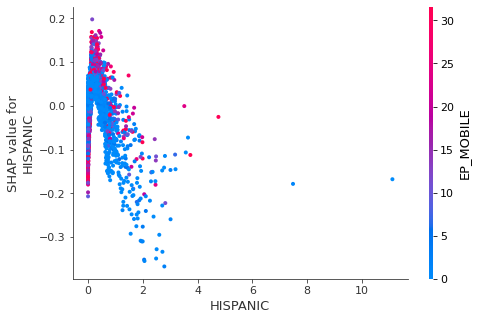

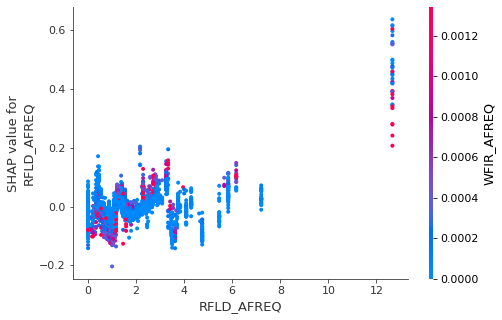

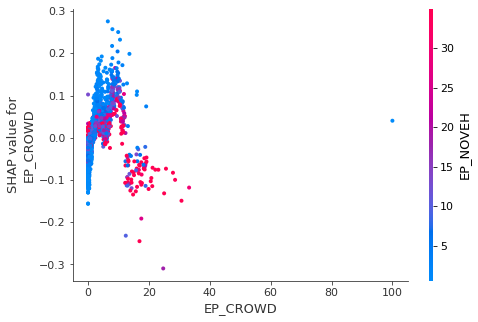

In [74]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(X_test.shape[1]):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

## Prepare a Data Frame with predictions and SHAP values

In [81]:
test_results_df = pd.DataFrame({'FIPS': test_df.loc[test_sel,'FIPS'], 'EVICTIONS': y_test, 'EVICTIONS_PREDICTED': y_pred_test})

In [82]:
test_results_df

FIPS  EVICTIONS  EVICTIONS_PREDICTED
0     01001020801GID   0.031377             0.186219
1     01003010705GID   0.436031             0.294574
2     01003010903GID   0.206540             0.428928
3     01003011000GID   0.262217             0.344457
4     01003011101GID   0.108460             0.166042
...              ...        ...                  ...
3003  55141010500GID   0.092109             0.231161
3004  55141010900GID   0.049554             0.101107
3005  55141011600GID   0.216365             0.091578
3006  56017967800GID   0.071098             0.077214
3007  56035000101GID   0.000000             0.044958

[2978 rows x 3 columns]